In [6]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd.functional import jacobian


torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM=2

TRAIN_SLOPE = 1
EVAL_SLOPE = 1
X_LOWER_BOUND = -30
X_UPPER_BOUND = 30

# Utils

In [8]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [9]:
def gen_custom_normal_data(N, x_dim, pos_mean, pos_std, neg_mean, neg_std):
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, x_dim))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, x_dim))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def gen_custom_sin_data(N, shuff=True):
    
    def func(x):
        return -(x**2)
    
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    
    posX = torch.linspace(-5, 0, pos_samples_num)
    posX = torch.stack([posX, func(posX)])
    posX = torch.transpose(posX, 1, 0)
    
    negX = torch.linspace(0, 5, neg_samples_num)
    negX = torch.stack([negX, func(negX)])
    negX = torch.transpose(negX, 1, 0)
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)
    if shuff:
        X, Y = shuffle(X, Y)
    else:
        Y = Y[:, 0]
    return X, Y

# CCP classes

In [10]:
class CCP:
    def __init__(self, x_dim, h_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)
        

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, B_SPAN, slope):
        """
        tensor to tensor
        """
        X = X.numpy()
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])
    
    
class CCP_MANIFOLD:
    def __init__(self, x_dim, h_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.v = cp.Variable(h_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.B_span = cp.Parameter((x_dim, h_dim))
        self.slope = cp.Parameter(1)
        

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND,
                      self.B_span@self.v == self.x-self.r]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r, B_span):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        self.B_span.value = B_span
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, B_SPAN, slope):
        """
        tensor to tensor
        """
        X = X.numpy()
        w = w.detach().numpy()
        b = b.detach().numpy()
        B_SPAN = B_SPAN.numpy()
        slope = np.full(1, slope)
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x, B_span)) for x, B_span in zip(X, B_SPAN)])

In [11]:
class DELTA():
    
    def __init__(self, x_dim, h_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
        
    def optimize_X(self, X, w, b, F_DER, B_SPAN):
        return self.layer(X, w, b, F_DER)[0]
    
class DELTA_MANIFOLD():
    
    def __init__(self, x_dim, h_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.v = cp.Variable(h_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.B_span = cp.Parameter((x_dim, h_dim), value = np.random.randn(x_dim, h_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND,
                      self.B_span@self.v == self.x-self.r]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der, self.B_span],
                                variables=[self.x, self.v])
        
        
    def optimize_X(self, X, w, b, F_DER, B_SPAN):
        return self.layer(X, w, b, F_DER, B_SPAN)[0]

# Gain & Cost functions

In [12]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r, x_dim):
    return cp.sum_squares(x-r)/70

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "score": score}

# CAE

In [13]:
class CAE(nn.Module):
    def __init__(self, x_dim, h_dim, h2_dim, lamb=0):
        torch.manual_seed(0)
        np.random.seed(0)
        super(CAE, self).__init__()
        
        self.lamb = lamb
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.h2_dim = h2_dim
        self.fc1 = nn.Linear(x_dim, h2_dim, bias = True) # Encoder
#         self.fc2 = nn.Linear(h2_dim, h2_dim, bias = True)
        self.fc3 = nn.Linear(h2_dim, h_dim, bias = True)
        self.fc4 = nn.Linear(h_dim, h2_dim, bias = True)
        self.fc5 = nn.Linear(h2_dim, h2_dim, bias = True)
#         self.fc6 = nn.Linear(h2_dim, h2_dim, bias = True)
        self.fc7 = nn.Linear(h2_dim, x_dim, bias = True)

        self.sigmoid = nn.Sigmoid()

    def encoder(self, x):
        o1 = self.sigmoid(self.fc1(x))
#         o2 = self.sigmoid(self.fc2(o1))
        o2 = self.sigmoid(self.fc3(o1))
        return o2
    
    def decoder(self, z):
        o1 = self.sigmoid(self.fc4(z))
        o2 = self.sigmoid(self.fc5(o1))
#         o3 = self.sigmoid(self.fc6(o2))
        return self.fc7(o2)

    def forward(self, x):
        h1 = self.encoder(x)
        h2 = self.decoder(h1)
        return h1, h2
        
    def save_model(self, path, comment=None):
        if comment is not None:
            path += "/" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
        
    def get_spans(self, X):
        def func(x):
            return self.forward(x)[0]
        
        B_SPANS = []
        for x in X:
            J = jacobian(func, x)
            U, S, _ = torch.svd(torch.transpose(J, 0, 1))
            B_span = U
            B_SPANS.append(B_span)
        return torch.stack(B_SPANS)
    
    def contractive_loss(self, x):
        def func(x):
            return self.encoder(x)
        J = jacobian(func, x, create_graph=True)
        c_loss = torch.norm(J, 2)**2
        return c_loss
    
    def reconstruction_loss(self, x, x_recons):
        mse_loss = nn.MSELoss(size_average = True)
        r_loss = mse_loss(x_recons, x)
        return r_loss
        
    def loss(self, x, x_recons, h):
        r_loss = self.reconstruction_loss(x, x_recons)
        c_loss = self.contractive_loss(x)
        return r_loss, c_loss

    def fit(self, path, X, Xval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, comment=None):
        train_dset = TensorDataset(X, torch.ones(len(X)))
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)
        
        best_val_loss = 100
        
        for epoch in range(epochs):
            total_r_loss = 0
            total_c_loss = 0
            train_loss = 0
            self.train()
            
            for idx, (Xbatch, _) in enumerate(train_loader):
                Xbatch = Variable(Xbatch)
                opt.zero_grad()
                
                hidden_representation, recons_x = self.forward(Xbatch)
                r_loss, c_loss = self.loss(Xbatch, recons_x, hidden_representation)
                l = r_loss + self.lamb*c_loss
                l.backward()
                train_loss += l.item()
                total_r_loss += r_loss.item()
                total_c_loss += c_loss.item()
                opt.step()

            
            hidden_representation, recons_x = self.forward(Xval)
            r_loss, c_loss = self.loss(Xval, recons_x, hidden_representation)
            l = r_loss + self.lamb*c_loss
            if l.item() < best_val_loss:
                self.save_model(path, comment)
                best_val_loss = l.item()
                print("model saved!")
                
            if verbose:
                print('====> Epoch: {} Average loss: {:.4f}'.format(
                     epoch, l.item()), " reconstruction loss: ", r_loss.item(), "contractive_loss: ", c_loss.item())

# Model

In [17]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, h_dim, funcs, train_slope, eval_slope, strategic=False, manifold=False):
        torch.manual_seed(0)
        np.random.seed(0)
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        self.strategic = strategic
        self.manifold = manifold
        if self.manifold:
            self.ccp_train = CCP_MANIFOLD(self.x_dim, self.h_dim, funcs)
            self.delta = DELTA_MANIFOLD(self.x_dim, self.h_dim, funcs)
        else:
            self.ccp_train = CCP(self.x_dim, self.h_dim, funcs)
            self.delta = DELTA(self.x_dim, self.h_dim, funcs)
        
        self.ccp_test = CCP_MANIFOLD(self.x_dim, self.h_dim, funcs)

    def forward(self, X, B_SPANS, evaluation=False):
        if self.strategic:            
            if evaluation:
                XT = self.ccp_train.optimize_X(X, self.w, self.b, B_SPANS, self.eval_slope)
                X_opt = XT
            else:
                XT = self.ccp_train.optimize_X(X, self.w, self.b, B_SPANS, self.train_slope)
                F_DER = self.get_f_ders(XT, self.train_slope)
                X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, B_SPANS) # Xopt should be equal to XT but we do it again for the gradients
                
            output = self.score(X_opt)
        else:
            output = self.score(X)        
        return output
    
    def optimize_X(self, X, B_SPANS):
        return self.ccp_test.optimize_X(X, self.w, self.b, B_SPANS, self.eval_slope)
    
    def normalize_weights(self):
        with torch.no_grad():
            norm = torch.sqrt(torch.sum(self.w**2) + self.b**2)
            self.w /= norm
            self.b /= norm
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def calc_accuracy(self, Y, Y_pred):
        Y_pred = torch.sign(Y_pred)
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def evaluate(self, X, B_SPANS, Y):      
        return self.calc_accuracy(Y, self.forward(X, B_SPANS, evaluation=True))
    
    def loss(self, Y, Y_pred):
        return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
    
    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, path, X, B_SPANS, Y, Xval, B_SPANSval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, comment=None):
        train_dset = TensorDataset(X, B_SPANS, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        
        best_val_error = 1
        consecutive_no_improvement = 0

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, B_SPANSbatch, Ybatch in train_loader:
                opt.zero_grad()
                Ybatch_pred = self.forward(Xbatch, B_SPANSbatch)
                l = self.loss(Ybatch, Ybatch_pred)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    e = self.calc_accuracy(Ybatch, Ybatch_pred)
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                Yval_pred = self.forward(Xval, B_SPANSval, evaluation=True)
                val_loss = self.loss(Yval, Yval_pred).item()
                val_losses.append(val_loss)
                val_error = 1-self.calc_accuracy(Yval, Yval_pred)
                val_errors.append(val_error)
                if val_error < best_val_error:
                    consecutive_no_improvement = 0
                    best_val_error = val_error
                    info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                    time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error)
                    self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                    print("model saved!")
                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break
                
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

# Data generation

torch.Size([1200, 2]) torch.Size([1200])


<IPython.core.display.Javascript object>


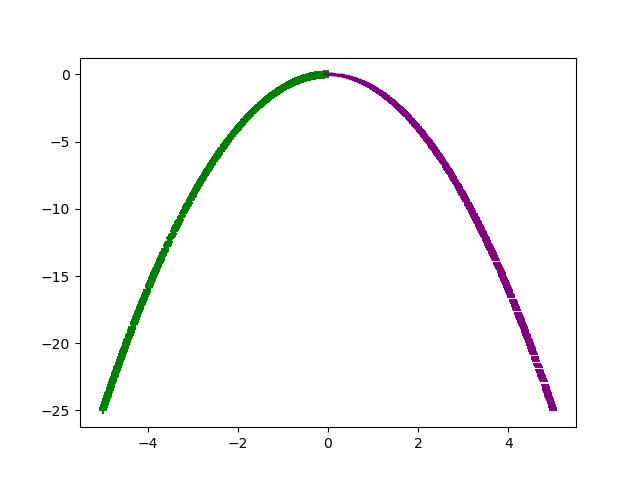

torch.Size([1200, 2]) torch.Size([400, 2])
percent of positive samples: 50.333333333333336%


In [15]:
N = 2000
x_dim = 2
h_dim = 1
h_dim2 = 20
X, Y = gen_custom_sin_data(N)
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)

print(X.size(), Y.size())
visualize_data(X, Y)
print(X.size(), Xval.size())
print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))


In [228]:
path = "./models/manifold/CAE"
cae = CAE(x_dim, h_dim, h_dim2, 100)
cae.fit(path, X, Xval, opt=torch.optim.Adam, opt_kwargs={"lr": (5e-2)}, batch_size=64, epochs=3000, verbose=True, comment='manifold')

model saved!
====> Epoch: 0 Average loss: 52.1230  reconstruction loss:  52.122942832240895 contractive_loss:  0.07314185198830825
model saved!
====> Epoch: 1 Average loss: 40.5996  reconstruction loss:  40.59964531173208 contractive_loss:  0.018530086353149247
model saved!
====> Epoch: 2 Average loss: 32.4609  reconstruction loss:  32.46090892089385 contractive_loss:  0.00587116691642836
model saved!
====> Epoch: 3 Average loss: 31.5265  reconstruction loss:  31.526528208106427 contractive_loss:  0.003590343110369815
====> Epoch: 4 Average loss: 31.6957  reconstruction loss:  31.695706060617905 contractive_loss:  0.002186180443766812
model saved!
====> Epoch: 5 Average loss: 31.4285  reconstruction loss:  31.428477793211176 contractive_loss:  0.0014266636241389013
model saved!
====> Epoch: 6 Average loss: 31.4076  reconstruction loss:  31.40761233389826 contractive_loss:  0.0010260920070327409
model saved!
====> Epoch: 7 Average loss: 31.3971  reconstruction loss:  31.397050885114385 

model saved!
====> Epoch: 66 Average loss: 4.4187  reconstruction loss:  4.418531469941298 contractive_loss:  1.660240294025856
model saved!
====> Epoch: 67 Average loss: 4.3885  reconstruction loss:  4.388352191984438 contractive_loss:  1.6698907657886526
====> Epoch: 68 Average loss: 4.4313  reconstruction loss:  4.431104251296076 contractive_loss:  1.6811304510385496
====> Epoch: 69 Average loss: 4.4390  reconstruction loss:  4.438851401131911 contractive_loss:  1.7031997031508197
model saved!
====> Epoch: 70 Average loss: 4.3791  reconstruction loss:  4.378949393509943 contractive_loss:  1.6974770729248645
====> Epoch: 71 Average loss: 4.3869  reconstruction loss:  4.386749062072116 contractive_loss:  1.7173031953755422
model saved!
====> Epoch: 72 Average loss: 4.3668  reconstruction loss:  4.366675107074451 contractive_loss:  1.7211057727437635
====> Epoch: 73 Average loss: 4.3898  reconstruction loss:  4.389597250227273 contractive_loss:  1.7560906338347113
====> Epoch: 74 Avera

====> Epoch: 135 Average loss: 4.2677  reconstruction loss:  4.267455274982371 contractive_loss:  2.9304634267410288
====> Epoch: 136 Average loss: 4.2757  reconstruction loss:  4.275361590296629 contractive_loss:  2.9276543325833524
====> Epoch: 137 Average loss: 4.2628  reconstruction loss:  4.262509137560327 contractive_loss:  2.966932167078735
====> Epoch: 138 Average loss: 4.2581  reconstruction loss:  4.257774210929474 contractive_loss:  2.966899559444813
====> Epoch: 139 Average loss: 4.2673  reconstruction loss:  4.266970020633462 contractive_loss:  2.9893408753537947
model saved!
====> Epoch: 140 Average loss: 4.2508  reconstruction loss:  4.25045043871825 contractive_loss:  3.002253272720524
====> Epoch: 141 Average loss: 4.2697  reconstruction loss:  4.269408557932996 contractive_loss:  2.9971408658476264
====> Epoch: 142 Average loss: 4.2656  reconstruction loss:  4.265270055634443 contractive_loss:  3.0227776467718734
model saved!
====> Epoch: 143 Average loss: 4.2482  rec

====> Epoch: 204 Average loss: 4.0501  reconstruction loss:  4.0499191201468205 contractive_loss:  1.3117514235975742
====> Epoch: 205 Average loss: 3.9961  reconstruction loss:  3.9960053497974695 contractive_loss:  1.2340546345477061
====> Epoch: 206 Average loss: 3.9964  reconstruction loss:  3.996234989559415 contractive_loss:  1.1678341501412384
model saved!
====> Epoch: 207 Average loss: 3.8744  reconstruction loss:  3.8743319709145947 contractive_loss:  1.1118023367959864
====> Epoch: 208 Average loss: 3.9410  reconstruction loss:  3.9409279504617865 contractive_loss:  1.0827063244364803
====> Epoch: 209 Average loss: 4.1405  reconstruction loss:  4.140348837624573 contractive_loss:  1.1337087139722668
====> Epoch: 210 Average loss: 4.0845  reconstruction loss:  4.084348447259429 contractive_loss:  1.1281090488076737
====> Epoch: 211 Average loss: 4.0101  reconstruction loss:  4.00994157207285 contractive_loss:  1.1917586669706346
====> Epoch: 212 Average loss: 3.8898  reconstru

====> Epoch: 273 Average loss: 3.7378  reconstruction loss:  3.7375689525336395 contractive_loss:  1.9225244175577196
====> Epoch: 274 Average loss: 4.5349  reconstruction loss:  4.534648815661101 contractive_loss:  2.554016790835226
====> Epoch: 275 Average loss: 4.4630  reconstruction loss:  4.462690230436909 contractive_loss:  2.9921732571149087
====> Epoch: 276 Average loss: 3.9799  reconstruction loss:  3.9795965364308006 contractive_loss:  2.706925928235097
====> Epoch: 277 Average loss: 4.1330  reconstruction loss:  4.132864563746791 contractive_loss:  1.6807747367193415
====> Epoch: 278 Average loss: 5.0319  reconstruction loss:  5.031672550016235 contractive_loss:  2.581614628840447
====> Epoch: 279 Average loss: 4.0100  reconstruction loss:  4.009702856471197 contractive_loss:  2.639109156507587
====> Epoch: 280 Average loss: 3.9185  reconstruction loss:  3.9182639990132926 contractive_loss:  2.6565022020382685
====> Epoch: 281 Average loss: 3.9449  reconstruction loss:  3.94

====> Epoch: 344 Average loss: 3.5441  reconstruction loss:  3.5435494114391632 contractive_loss:  5.338153529855853
====> Epoch: 345 Average loss: 3.1951  reconstruction loss:  3.1946628921903244 contractive_loss:  4.2113914767867575
====> Epoch: 346 Average loss: 4.0606  reconstruction loss:  4.060162563563321 contractive_loss:  4.718670130322061
====> Epoch: 347 Average loss: 3.9379  reconstruction loss:  3.9372346572394497 contractive_loss:  6.168063571488899
====> Epoch: 348 Average loss: 7.1301  reconstruction loss:  7.129516874580654 contractive_loss:  5.507833166610857
====> Epoch: 349 Average loss: 7.2330  reconstruction loss:  7.2325051102024975 contractive_loss:  4.566902255280355
====> Epoch: 350 Average loss: 5.8228  reconstruction loss:  5.822227043383712 contractive_loss:  5.94606600609216
====> Epoch: 351 Average loss: 4.8865  reconstruction loss:  4.885604581047772 contractive_loss:  9.41991993291551
====> Epoch: 352 Average loss: 6.7703  reconstruction loss:  6.769628

====> Epoch: 415 Average loss: 3.3137  reconstruction loss:  3.313661035258585 contractive_loss:  0.6087710662057795
====> Epoch: 416 Average loss: 3.7903  reconstruction loss:  3.7902083322016136 contractive_loss:  0.8397592985089634
====> Epoch: 417 Average loss: 3.1118  reconstruction loss:  3.111750538629136 contractive_loss:  0.5558777586594256
====> Epoch: 418 Average loss: 3.1866  reconstruction loss:  3.1865282773836294 contractive_loss:  0.8829130165087535
====> Epoch: 419 Average loss: 2.8924  reconstruction loss:  2.892291427973565 contractive_loss:  1.1946869460830662
====> Epoch: 420 Average loss: 3.0833  reconstruction loss:  3.083189966757202 contractive_loss:  1.1600693498820462
====> Epoch: 421 Average loss: 4.1436  reconstruction loss:  4.14346015545988 contractive_loss:  1.0365351248480152
====> Epoch: 422 Average loss: 4.0488  reconstruction loss:  4.048708038522397 contractive_loss:  0.47090058223979286
====> Epoch: 423 Average loss: 3.6001  reconstruction loss:  3

====> Epoch: 485 Average loss: 3.8788  reconstruction loss:  3.8784508552076677 contractive_loss:  3.2837130320147767
====> Epoch: 486 Average loss: 3.0459  reconstruction loss:  3.045666555749498 contractive_loss:  2.2752576882942197
====> Epoch: 487 Average loss: 3.3541  reconstruction loss:  3.353842711300887 contractive_loss:  2.915111052558736
model saved!
====> Epoch: 488 Average loss: 2.5474  reconstruction loss:  2.5472846670134204 contractive_loss:  1.324181119297353
====> Epoch: 489 Average loss: 3.0192  reconstruction loss:  3.0190851897462276 contractive_loss:  1.392524106746981
====> Epoch: 490 Average loss: 3.4020  reconstruction loss:  3.401882257401729 contractive_loss:  0.8104365962182044
====> Epoch: 491 Average loss: 2.8725  reconstruction loss:  2.8724489740095356 contractive_loss:  0.6946139335214363
====> Epoch: 492 Average loss: 3.0931  reconstruction loss:  3.0929679607911793 contractive_loss:  0.9835283207645185
====> Epoch: 493 Average loss: 2.7191  reconstruc

====> Epoch: 555 Average loss: 2.7012  reconstruction loss:  2.701076320463089 contractive_loss:  0.856807828946873
====> Epoch: 556 Average loss: 2.9919  reconstruction loss:  2.9917909775927956 contractive_loss:  1.448965358488121
====> Epoch: 557 Average loss: 2.7561  reconstruction loss:  2.7559872863456154 contractive_loss:  1.213931867761534
====> Epoch: 558 Average loss: 3.1043  reconstruction loss:  3.1041924368401714 contractive_loss:  1.001675429841034
====> Epoch: 559 Average loss: 2.8345  reconstruction loss:  2.83436432887665 contractive_loss:  0.8691882730427563
====> Epoch: 560 Average loss: 2.5243  reconstruction loss:  2.5242140814631973 contractive_loss:  0.9752213849574729
====> Epoch: 561 Average loss: 3.2085  reconstruction loss:  3.208306611233303 contractive_loss:  2.2838439826983157
====> Epoch: 562 Average loss: 2.8500  reconstruction loss:  2.8497456711481526 contractive_loss:  2.2854432918448078
====> Epoch: 563 Average loss: 2.7400  reconstruction loss:  2.7

====> Epoch: 625 Average loss: 2.7230  reconstruction loss:  2.7229437042743827 contractive_loss:  0.776622094436516
====> Epoch: 626 Average loss: 2.6932  reconstruction loss:  2.6930694472555046 contractive_loss:  0.828392553021397
====> Epoch: 627 Average loss: 3.3218  reconstruction loss:  3.3216784617781445 contractive_loss:  1.6553190119355523
====> Epoch: 628 Average loss: 2.8822  reconstruction loss:  2.882046631237113 contractive_loss:  1.9373031304716728
====> Epoch: 629 Average loss: 2.5259  reconstruction loss:  2.5257283256523637 contractive_loss:  1.276429004561436
====> Epoch: 630 Average loss: 3.9301  reconstruction loss:  3.929711122578563 contractive_loss:  3.4598532056454676
====> Epoch: 631 Average loss: 3.5325  reconstruction loss:  3.5321826610201583 contractive_loss:  3.212598151046209
====> Epoch: 632 Average loss: 3.8458  reconstruction loss:  3.845444856616142 contractive_loss:  3.542287341669842
====> Epoch: 633 Average loss: 3.5009  reconstruction loss:  3.5

====> Epoch: 696 Average loss: 3.2151  reconstruction loss:  3.2147362232121424 contractive_loss:  3.2695571262729435
====> Epoch: 697 Average loss: 3.3753  reconstruction loss:  3.3749810124203985 contractive_loss:  3.4189501481430202
====> Epoch: 698 Average loss: 3.2196  reconstruction loss:  3.2194734702048904 contractive_loss:  1.6639403179606755
====> Epoch: 699 Average loss: 2.9060  reconstruction loss:  2.905936081369802 contractive_loss:  1.014288728349956
====> Epoch: 700 Average loss: 2.7119  reconstruction loss:  2.711724295118705 contractive_loss:  1.3926634526815236
====> Epoch: 701 Average loss: 2.8611  reconstruction loss:  2.860951585996362 contractive_loss:  1.7072289021259452
model saved!
====> Epoch: 702 Average loss: 2.3744  reconstruction loss:  2.374224953877841 contractive_loss:  1.3379330476904916
====> Epoch: 703 Average loss: 2.7297  reconstruction loss:  2.729397652080898 contractive_loss:  3.062532983842871
====> Epoch: 704 Average loss: 4.0989  reconstruct

====> Epoch: 766 Average loss: 2.7772  reconstruction loss:  2.7771115675471867 contractive_loss:  0.7725903179436899
====> Epoch: 767 Average loss: 2.8009  reconstruction loss:  2.800825983686367 contractive_loss:  1.0970683962897916
====> Epoch: 768 Average loss: 3.1353  reconstruction loss:  3.135166873168488 contractive_loss:  1.179934026341423
====> Epoch: 769 Average loss: 2.8351  reconstruction loss:  2.834946736321094 contractive_loss:  1.6486011947500674
====> Epoch: 770 Average loss: 3.2836  reconstruction loss:  3.2833437456413246 contractive_loss:  2.5376101717639323
====> Epoch: 771 Average loss: 5.9135  reconstruction loss:  5.913420001636974 contractive_loss:  1.1680654065434974
====> Epoch: 772 Average loss: 7.4378  reconstruction loss:  7.437404510538783 contractive_loss:  4.20767254054165
====> Epoch: 773 Average loss: 6.1638  reconstruction loss:  6.163451602113021 contractive_loss:  3.9789900938328624
====> Epoch: 774 Average loss: 5.1589  reconstruction loss:  5.15

====> Epoch: 836 Average loss: 2.7961  reconstruction loss:  2.79593438144531 contractive_loss:  2.0958441255560576
====> Epoch: 837 Average loss: 2.7506  reconstruction loss:  2.7503651527718858 contractive_loss:  2.2961600092748293
====> Epoch: 838 Average loss: 2.4481  reconstruction loss:  2.447890594568589 contractive_loss:  2.558382925592638
====> Epoch: 839 Average loss: 2.2110  reconstruction loss:  2.2107580967620697 contractive_loss:  2.312855386701671
====> Epoch: 840 Average loss: 2.7067  reconstruction loss:  2.706459353731913 contractive_loss:  2.7594645609840867
====> Epoch: 841 Average loss: 2.6135  reconstruction loss:  2.613193467078654 contractive_loss:  2.9367954214126097
====> Epoch: 842 Average loss: 2.5759  reconstruction loss:  2.5755888793519985 contractive_loss:  2.6693077039297437
====> Epoch: 843 Average loss: 2.6833  reconstruction loss:  2.682861422444567 contractive_loss:  4.082348675461855
====> Epoch: 844 Average loss: 2.8447  reconstruction loss:  2.84

====> Epoch: 906 Average loss: 2.3638  reconstruction loss:  2.3636263112020837 contractive_loss:  1.2824525791393884
====> Epoch: 907 Average loss: 2.3712  reconstruction loss:  2.371020775960304 contractive_loss:  1.4726227661729545
====> Epoch: 908 Average loss: 2.1152  reconstruction loss:  2.1150520849890686 contractive_loss:  1.413765305957155
====> Epoch: 909 Average loss: 2.3441  reconstruction loss:  2.343778994153006 contractive_loss:  2.7578359022042145
====> Epoch: 910 Average loss: 2.4684  reconstruction loss:  2.4680909175150045 contractive_loss:  3.0468736257076836
====> Epoch: 911 Average loss: 2.2155  reconstruction loss:  2.2152150969984863 contractive_loss:  2.509361098164951
====> Epoch: 912 Average loss: 2.3265  reconstruction loss:  2.3262776098246563 contractive_loss:  2.6309655403328853
====> Epoch: 913 Average loss: 2.2248  reconstruction loss:  2.22459204144892 contractive_loss:  1.7159823667359875
====> Epoch: 914 Average loss: 2.1805  reconstruction loss:  2

====> Epoch: 976 Average loss: 2.7359  reconstruction loss:  2.7358000473413666 contractive_loss:  0.7029260269262397
====> Epoch: 977 Average loss: 2.5446  reconstruction loss:  2.5445754369006277 contractive_loss:  0.5107796556221559
====> Epoch: 978 Average loss: 3.0217  reconstruction loss:  3.021664994796959 contractive_loss:  0.8465120672284095
====> Epoch: 979 Average loss: 2.5657  reconstruction loss:  2.565690736854783 contractive_loss:  0.44219394809838597
====> Epoch: 980 Average loss: 2.7008  reconstruction loss:  2.7008057249589137 contractive_loss:  0.39297193358729293
====> Epoch: 981 Average loss: 3.2807  reconstruction loss:  3.2806213752889573 contractive_loss:  0.8337080218891368
====> Epoch: 982 Average loss: 3.1658  reconstruction loss:  3.165715876562223 contractive_loss:  0.8164493909925346
====> Epoch: 983 Average loss: 3.5162  reconstruction loss:  3.5161667525176563 contractive_loss:  0.43544034911197
====> Epoch: 984 Average loss: 3.1638  reconstruction loss:

====> Epoch: 1046 Average loss: 2.7646  reconstruction loss:  2.7645397824500213 contractive_loss:  1.0448454700443373
====> Epoch: 1047 Average loss: 3.4181  reconstruction loss:  3.4179973826866172 contractive_loss:  0.8532841199475893
====> Epoch: 1048 Average loss: 4.0710  reconstruction loss:  4.070992896315292 contractive_loss:  0.5360198323645217
====> Epoch: 1049 Average loss: 3.8364  reconstruction loss:  3.8363331845592255 contractive_loss:  0.5553382415468527
====> Epoch: 1050 Average loss: 3.3456  reconstruction loss:  3.34547574056013 contractive_loss:  0.8041902360046981
====> Epoch: 1051 Average loss: 3.6903  reconstruction loss:  3.6902475261966483 contractive_loss:  0.6207630275923659
====> Epoch: 1052 Average loss: 3.3633  reconstruction loss:  3.3632296738509546 contractive_loss:  0.7363829055418121
====> Epoch: 1053 Average loss: 3.5914  reconstruction loss:  3.591363970618295 contractive_loss:  0.6886887606943501
====> Epoch: 1054 Average loss: 3.3252  reconstructi

====> Epoch: 1115 Average loss: 3.2199  reconstruction loss:  3.219823732833885 contractive_loss:  1.059001100147825
====> Epoch: 1116 Average loss: 2.5087  reconstruction loss:  2.5085248545867094 contractive_loss:  1.6693386576227052
====> Epoch: 1117 Average loss: 2.2873  reconstruction loss:  2.287190285463846 contractive_loss:  0.7885928961061814
====> Epoch: 1118 Average loss: 2.4880  reconstruction loss:  2.487916147773109 contractive_loss:  1.1244559420273743
====> Epoch: 1119 Average loss: 2.8694  reconstruction loss:  2.8692892016905205 contractive_loss:  1.3084223811310611
====> Epoch: 1120 Average loss: 3.4466  reconstruction loss:  3.446462108491337 contractive_loss:  1.375688562879402
====> Epoch: 1121 Average loss: 2.4947  reconstruction loss:  2.4945924099397185 contractive_loss:  1.0271434361324012
====> Epoch: 1122 Average loss: 2.6374  reconstruction loss:  2.637303924247984 contractive_loss:  0.8481185113623715
====> Epoch: 1123 Average loss: 2.4841  reconstruction 

====> Epoch: 1185 Average loss: 2.6129  reconstruction loss:  2.6127875261065587 contractive_loss:  1.4093981620168277
====> Epoch: 1186 Average loss: 3.2062  reconstruction loss:  3.2059615376979607 contractive_loss:  2.1421448156755907
====> Epoch: 1187 Average loss: 3.4533  reconstruction loss:  3.4531039954078193 contractive_loss:  2.0576204870721853
====> Epoch: 1188 Average loss: 3.5216  reconstruction loss:  3.5215376535644225 contractive_loss:  0.9380572112697289
====> Epoch: 1189 Average loss: 2.6191  reconstruction loss:  2.6189827875674676 contractive_loss:  1.6335114377171236
====> Epoch: 1190 Average loss: 3.2810  reconstruction loss:  3.2808297984737265 contractive_loss:  2.1509863814436123
====> Epoch: 1191 Average loss: 3.0008  reconstruction loss:  3.0006276382494708 contractive_loss:  1.8412693313991848
====> Epoch: 1192 Average loss: 2.8413  reconstruction loss:  2.841240001585553 contractive_loss:  0.8061421821866311
====> Epoch: 1193 Average loss: 3.0759  reconstru

====> Epoch: 1255 Average loss: 2.0670  reconstruction loss:  2.0668267893322296 contractive_loss:  2.065824101812014
====> Epoch: 1256 Average loss: 2.2647  reconstruction loss:  2.264570554211438 contractive_loss:  1.7428615673270516
====> Epoch: 1257 Average loss: 1.6655  reconstruction loss:  1.6653042022696056 contractive_loss:  2.183556262974639
====> Epoch: 1258 Average loss: 2.5335  reconstruction loss:  2.5333065569204773 contractive_loss:  1.809548676949081
====> Epoch: 1259 Average loss: 1.8921  reconstruction loss:  1.8919451994410559 contractive_loss:  1.850787585551707
====> Epoch: 1260 Average loss: 2.0403  reconstruction loss:  2.040110525758653 contractive_loss:  1.9134893788724303
====> Epoch: 1261 Average loss: 2.7605  reconstruction loss:  2.7601223074181847 contractive_loss:  3.5207017118909025
====> Epoch: 1262 Average loss: 2.4366  reconstruction loss:  2.43613337589583 contractive_loss:  4.545734855655561
====> Epoch: 1263 Average loss: 2.5333  reconstruction lo

====> Epoch: 1325 Average loss: 2.2530  reconstruction loss:  2.2526844997242783 contractive_loss:  2.8985393121751493
====> Epoch: 1326 Average loss: 2.4340  reconstruction loss:  2.4334655112207897 contractive_loss:  5.646995420943512
====> Epoch: 1327 Average loss: 2.2128  reconstruction loss:  2.212285964334572 contractive_loss:  5.32222937936526
====> Epoch: 1328 Average loss: 2.5095  reconstruction loss:  2.508978367452743 contractive_loss:  4.721074005089989
====> Epoch: 1329 Average loss: 2.5891  reconstruction loss:  2.5885987658597456 contractive_loss:  5.195703689457172
====> Epoch: 1330 Average loss: 1.5963  reconstruction loss:  1.5960009929989332 contractive_loss:  3.100487527503102
====> Epoch: 1331 Average loss: 1.8348  reconstruction loss:  1.8344426795171205 contractive_loss:  3.1320427375493316
====> Epoch: 1332 Average loss: 2.1099  reconstruction loss:  2.1095112931190667 contractive_loss:  4.225736704931016
====> Epoch: 1333 Average loss: 1.8973  reconstruction lo

====> Epoch: 1395 Average loss: 1.5183  reconstruction loss:  1.5180873351449293 contractive_loss:  1.7967297149121018
====> Epoch: 1396 Average loss: 1.1373  reconstruction loss:  1.1370813282749186 contractive_loss:  1.8879157182387656
====> Epoch: 1397 Average loss: 1.2878  reconstruction loss:  1.2869231648284067 contractive_loss:  8.81828516515218
====> Epoch: 1398 Average loss: 2.2026  reconstruction loss:  2.201550112638432 contractive_loss:  10.536573153808554
====> Epoch: 1399 Average loss: 1.8918  reconstruction loss:  1.8906753019892395 contractive_loss:  11.225226316488394
====> Epoch: 1400 Average loss: 1.3164  reconstruction loss:  1.3162541185778573 contractive_loss:  1.6172539861568396
====> Epoch: 1401 Average loss: 3.4893  reconstruction loss:  3.4885593547563247 contractive_loss:  7.161865588786543
====> Epoch: 1402 Average loss: 2.2855  reconstruction loss:  2.2847441547303866 contractive_loss:  7.438018782110941
====> Epoch: 1403 Average loss: 1.7053  reconstructio

====> Epoch: 1465 Average loss: 1.3892  reconstruction loss:  1.3882608948635373 contractive_loss:  9.265299917268527
====> Epoch: 1466 Average loss: 1.9076  reconstruction loss:  1.9066718454419829 contractive_loss:  9.142323701735421
====> Epoch: 1467 Average loss: 1.1738  reconstruction loss:  1.1728441358094002 contractive_loss:  9.646211973469308
====> Epoch: 1468 Average loss: 1.1294  reconstruction loss:  1.128425647640046 contractive_loss:  10.05711644237337
====> Epoch: 1469 Average loss: 1.2168  reconstruction loss:  1.2158772160389342 contractive_loss:  9.295617373589648
====> Epoch: 1470 Average loss: 1.7362  reconstruction loss:  1.735552590476635 contractive_loss:  6.1679643428579425
====> Epoch: 1471 Average loss: 1.5537  reconstruction loss:  1.5531258540309656 contractive_loss:  5.25693264035922
====> Epoch: 1472 Average loss: 1.0190  reconstruction loss:  1.0180310963556254 contractive_loss:  10.169653193181968
====> Epoch: 1473 Average loss: 1.4496  reconstruction lo

====> Epoch: 1534 Average loss: 1.9619  reconstruction loss:  1.9588879854907089 contractive_loss:  30.20952114999197
====> Epoch: 1535 Average loss: 1.5890  reconstruction loss:  1.5861953842788 contractive_loss:  28.174666886152266
====> Epoch: 1536 Average loss: 1.7576  reconstruction loss:  1.7545187416568284 contractive_loss:  30.487730310467775
====> Epoch: 1537 Average loss: 1.3237  reconstruction loss:  1.3223367499856606 contractive_loss:  13.880989163626705
====> Epoch: 1538 Average loss: 1.1056  reconstruction loss:  1.1054441858490738 contractive_loss:  1.0860166276456642
====> Epoch: 1539 Average loss: 0.8039  reconstruction loss:  0.803652128744969 contractive_loss:  2.5982437586494362
====> Epoch: 1540 Average loss: 1.9559  reconstruction loss:  1.9556593309072168 contractive_loss:  2.426580025806154
====> Epoch: 1541 Average loss: 1.0652  reconstruction loss:  1.0650849219502756 contractive_loss:  1.020531079054531
====> Epoch: 1542 Average loss: 0.6876  reconstruction 

====> Epoch: 1604 Average loss: 0.5555  reconstruction loss:  0.5537533926805644 contractive_loss:  17.85642660061882
====> Epoch: 1605 Average loss: 1.5225  reconstruction loss:  1.5203073615314457 contractive_loss:  21.71618199647381
====> Epoch: 1606 Average loss: 1.3440  reconstruction loss:  1.3417222148930685 contractive_loss:  22.57663476734802
====> Epoch: 1607 Average loss: 2.0661  reconstruction loss:  2.063943076844489 contractive_loss:  21.340789667367407
====> Epoch: 1608 Average loss: 0.7613  reconstruction loss:  0.7593660325564057 contractive_loss:  19.424702534366734
====> Epoch: 1609 Average loss: 0.7210  reconstruction loss:  0.7191187344407416 contractive_loss:  18.612542225932067
====> Epoch: 1610 Average loss: 1.1014  reconstruction loss:  1.0993732969542644 contractive_loss:  19.884410278615775
====> Epoch: 1611 Average loss: 1.4259  reconstruction loss:  1.4237892958657283 contractive_loss:  21.03158916056766
====> Epoch: 1612 Average loss: 0.7851  reconstructio

====> Epoch: 1673 Average loss: 2.0036  reconstruction loss:  2.002278842580098 contractive_loss:  13.30955514113621
====> Epoch: 1674 Average loss: 1.3236  reconstruction loss:  1.3208786027887829 contractive_loss:  27.686756129667067
====> Epoch: 1675 Average loss: 1.9189  reconstruction loss:  1.915208774473793 contractive_loss:  36.75394111589219
====> Epoch: 1676 Average loss: 3.0014  reconstruction loss:  2.9990324160104165 contractive_loss:  23.838438755870346
====> Epoch: 1677 Average loss: 2.3900  reconstruction loss:  2.387621682377339 contractive_loss:  23.38773434373361
====> Epoch: 1678 Average loss: 1.9833  reconstruction loss:  1.980990226621888 contractive_loss:  23.316222238512122
====> Epoch: 1679 Average loss: 1.8354  reconstruction loss:  1.832876069465418 contractive_loss:  24.914883066958108
====> Epoch: 1680 Average loss: 1.5325  reconstruction loss:  1.5297745356515733 contractive_loss:  27.048068810633566
====> Epoch: 1681 Average loss: 1.6697  reconstruction l

====> Epoch: 1743 Average loss: 2.3126  reconstruction loss:  2.305064204080293 contractive_loss:  75.36367818014233
====> Epoch: 1744 Average loss: 0.7992  reconstruction loss:  0.7922790870950487 contractive_loss:  69.05058030063522
====> Epoch: 1745 Average loss: 0.5058  reconstruction loss:  0.49859571063520136 contractive_loss:  71.66828370222954
====> Epoch: 1746 Average loss: 1.6072  reconstruction loss:  1.5996886275113866 contractive_loss:  75.00879323541051
====> Epoch: 1747 Average loss: 1.6897  reconstruction loss:  1.6822204855862577 contractive_loss:  75.20307717083836
====> Epoch: 1748 Average loss: 2.0532  reconstruction loss:  2.045602885281068 contractive_loss:  75.47561430086998
====> Epoch: 1749 Average loss: 1.2858  reconstruction loss:  1.2784332309548576 contractive_loss:  74.05090055598471
====> Epoch: 1750 Average loss: 0.6089  reconstruction loss:  0.6018234237677502 contractive_loss:  70.86634761028405
====> Epoch: 1751 Average loss: 1.5761  reconstruction lo

====> Epoch: 1813 Average loss: 0.5597  reconstruction loss:  0.5582472835849671 contractive_loss:  14.14452301658048
====> Epoch: 1814 Average loss: 0.4278  reconstruction loss:  0.4256776997899257 contractive_loss:  20.86773952580378
====> Epoch: 1815 Average loss: 0.8989  reconstruction loss:  0.8973266178284272 contractive_loss:  16.086627543530103
====> Epoch: 1816 Average loss: 0.4868  reconstruction loss:  0.4865111831367757 contractive_loss:  2.777366614555211
====> Epoch: 1817 Average loss: 0.4999  reconstruction loss:  0.4996898827134746 contractive_loss:  2.446665887643193
====> Epoch: 1818 Average loss: 0.3872  reconstruction loss:  0.3868822873256764 contractive_loss:  3.036393077236278
====> Epoch: 1819 Average loss: 0.4704  reconstruction loss:  0.4701981213105269 contractive_loss:  2.2525894020196224
====> Epoch: 1820 Average loss: 0.4396  reconstruction loss:  0.4392812698146814 contractive_loss:  2.984039425332449
====> Epoch: 1821 Average loss: 0.3245  reconstruction

====> Epoch: 1883 Average loss: 1.8326  reconstruction loss:  1.825657582405998 contractive_loss:  69.50125853267203
====> Epoch: 1884 Average loss: 1.4597  reconstruction loss:  1.4529503444709186 contractive_loss:  67.83141597569703
====> Epoch: 1885 Average loss: 1.7022  reconstruction loss:  1.6952069736173154 contractive_loss:  70.12273209171718
====> Epoch: 1886 Average loss: 0.9234  reconstruction loss:  0.9169858167538568 contractive_loss:  64.15567195244229
====> Epoch: 1887 Average loss: 1.4780  reconstruction loss:  1.470813356554042 contractive_loss:  72.22681578472954
====> Epoch: 1888 Average loss: 1.1914  reconstruction loss:  1.1835077541401438 contractive_loss:  79.24106776043857
====> Epoch: 1889 Average loss: 1.0771  reconstruction loss:  1.0694565511482272 contractive_loss:  76.18122753200885
====> Epoch: 1890 Average loss: 1.6385  reconstruction loss:  1.6308613621473538 contractive_loss:  76.43581804954037
====> Epoch: 1891 Average loss: 1.5412  reconstruction los

====> Epoch: 1953 Average loss: 2.3063  reconstruction loss:  2.30223873126619 contractive_loss:  40.16012587991662
====> Epoch: 1954 Average loss: 1.7388  reconstruction loss:  1.7347819059402065 contractive_loss:  40.26996081701975
====> Epoch: 1955 Average loss: 1.7781  reconstruction loss:  1.7740963581913984 contractive_loss:  40.28652448501676
====> Epoch: 1956 Average loss: 1.9168  reconstruction loss:  1.9127261220018148 contractive_loss:  40.242829021737755
====> Epoch: 1957 Average loss: 1.8904  reconstruction loss:  1.8863417507476703 contractive_loss:  40.18904296385357
====> Epoch: 1958 Average loss: 1.6155  reconstruction loss:  1.6115078190390326 contractive_loss:  40.114807923911115
====> Epoch: 1959 Average loss: 1.4279  reconstruction loss:  1.423907131439153 contractive_loss:  40.09440711350392
====> Epoch: 1960 Average loss: 1.5983  reconstruction loss:  1.5942708086099777 contractive_loss:  39.99941291233068
====> Epoch: 1961 Average loss: 1.5942  reconstruction lo

====> Epoch: 2023 Average loss: 2.0756  reconstruction loss:  2.0719872738942895 contractive_loss:  36.49222439335505
====> Epoch: 2024 Average loss: 2.1353  reconstruction loss:  2.1316799048366635 contractive_loss:  36.407851660721114
====> Epoch: 2025 Average loss: 1.7788  reconstruction loss:  1.7750959908723614 contractive_loss:  36.91865642635532
====> Epoch: 2026 Average loss: 1.8555  reconstruction loss:  1.8518710296489482 contractive_loss:  36.558502386501104
====> Epoch: 2027 Average loss: 1.7665  reconstruction loss:  1.7627927757318855 contractive_loss:  36.74920173896592
model saved!
====> Epoch: 2028 Average loss: 0.2283  reconstruction loss:  0.22441520439790033 contractive_loss:  38.4346004986588
====> Epoch: 2029 Average loss: 1.8998  reconstruction loss:  1.895997167478756 contractive_loss:  37.58834926502574
====> Epoch: 2030 Average loss: 1.9574  reconstruction loss:  1.953637187317415 contractive_loss:  37.87131557915878
====> Epoch: 2031 Average loss: 0.2622  rec

====> Epoch: 2093 Average loss: 0.9896  reconstruction loss:  0.9863424522407079 contractive_loss:  32.14951087555133
====> Epoch: 2094 Average loss: 1.9920  reconstruction loss:  1.9888923932759495 contractive_loss:  30.93900988193298
====> Epoch: 2095 Average loss: 1.8425  reconstruction loss:  1.8394079214534023 contractive_loss:  30.890434306499532
====> Epoch: 2096 Average loss: 1.8306  reconstruction loss:  1.8275673120701519 contractive_loss:  30.521246874964717
====> Epoch: 2097 Average loss: 0.6898  reconstruction loss:  0.6864603305931695 contractive_loss:  33.45711933849717
====> Epoch: 2098 Average loss: 0.3988  reconstruction loss:  0.3954785547984168 contractive_loss:  33.11821111824857
====> Epoch: 2099 Average loss: 0.1973  reconstruction loss:  0.19406562570097186 contractive_loss:  32.3489738488377
====> Epoch: 2100 Average loss: 0.9583  reconstruction loss:  0.9554190949808445 contractive_loss:  28.401808058517865
====> Epoch: 2101 Average loss: 2.0026  reconstructio

====> Epoch: 2163 Average loss: 0.9185  reconstruction loss:  0.9141491124649671 contractive_loss:  43.73579472176254
====> Epoch: 2164 Average loss: 0.3785  reconstruction loss:  0.3737343058445429 contractive_loss:  48.13169509525782
====> Epoch: 2165 Average loss: 0.2829  reconstruction loss:  0.2780316053684746 contractive_loss:  48.6806669919978
====> Epoch: 2166 Average loss: 1.6098  reconstruction loss:  1.6050683020828496 contractive_loss:  46.88979601472225
====> Epoch: 2167 Average loss: 1.4523  reconstruction loss:  1.4476084175158643 contractive_loss:  46.883042508287
====> Epoch: 2168 Average loss: 1.4741  reconstruction loss:  1.4693877322823967 contractive_loss:  46.66367192630509
====> Epoch: 2169 Average loss: 1.4474  reconstruction loss:  1.4427415872762779 contractive_loss:  46.382154322720396
====> Epoch: 2170 Average loss: 1.6884  reconstruction loss:  1.6837389532874036 contractive_loss:  46.44445385498349
====> Epoch: 2171 Average loss: 1.5789  reconstruction los

====> Epoch: 2233 Average loss: 0.5685  reconstruction loss:  0.564482982837947 contractive_loss:  40.16166712326838
====> Epoch: 2234 Average loss: 0.8079  reconstruction loss:  0.8040271431570218 contractive_loss:  39.120764564939115
====> Epoch: 2235 Average loss: 0.2443  reconstruction loss:  0.24028777057993259 contractive_loss:  40.424644915841945
====> Epoch: 2236 Average loss: 1.2515  reconstruction loss:  1.2484912716897358 contractive_loss:  30.257915922741336
====> Epoch: 2237 Average loss: 1.1516  reconstruction loss:  1.1484908183325504 contractive_loss:  31.240245290710092
====> Epoch: 2238 Average loss: 0.9565  reconstruction loss:  0.9523926163288533 contractive_loss:  40.84473633945491
====> Epoch: 2239 Average loss: 0.7730  reconstruction loss:  0.7693358010449529 contractive_loss:  37.13989712705664
====> Epoch: 2240 Average loss: 1.1982  reconstruction loss:  1.1939827490515076 contractive_loss:  42.64100543987497
====> Epoch: 2241 Average loss: 2.3309  reconstructi

====> Epoch: 2303 Average loss: 1.7095  reconstruction loss:  1.7058530911319287 contractive_loss:  36.196044642653376
====> Epoch: 2304 Average loss: 1.6759  reconstruction loss:  1.6722416651234298 contractive_loss:  36.184031564415086
====> Epoch: 2305 Average loss: 1.8705  reconstruction loss:  1.8669694845573286 contractive_loss:  35.72053907950084
====> Epoch: 2306 Average loss: 1.7092  reconstruction loss:  1.7055995714108467 contractive_loss:  35.541872271283026
====> Epoch: 2307 Average loss: 1.7838  reconstruction loss:  1.7802304980285655 contractive_loss:  35.44974876416103
====> Epoch: 2308 Average loss: 1.6491  reconstruction loss:  1.645472511763671 contractive_loss:  35.7930269177471
====> Epoch: 2309 Average loss: 1.1375  reconstruction loss:  1.1338910464660754 contractive_loss:  36.30942390749371
====> Epoch: 2310 Average loss: 1.6017  reconstruction loss:  1.5981321861977733 contractive_loss:  35.47348233086572
====> Epoch: 2311 Average loss: 2.1938  reconstruction 

====> Epoch: 2373 Average loss: 1.6176  reconstruction loss:  1.6142849682750957 contractive_loss:  33.41613562816038
====> Epoch: 2374 Average loss: 1.9733  reconstruction loss:  1.9699424109676633 contractive_loss:  33.321177237035705
====> Epoch: 2375 Average loss: 1.5966  reconstruction loss:  1.59333045373383 contractive_loss:  32.73235184019075
====> Epoch: 2376 Average loss: 1.5613  reconstruction loss:  1.5579647488574475 contractive_loss:  33.34641238738939
====> Epoch: 2377 Average loss: 0.2526  reconstruction loss:  0.24903091675312183 contractive_loss:  35.67425971129121
====> Epoch: 2378 Average loss: 0.1972  reconstruction loss:  0.19383781146378984 contractive_loss:  34.093920000464536
====> Epoch: 2379 Average loss: 0.8114  reconstruction loss:  0.8080668944213901 contractive_loss:  33.590373663198186
====> Epoch: 2380 Average loss: 1.6257  reconstruction loss:  1.6223684467405952 contractive_loss:  33.184425732780106
====> Epoch: 2381 Average loss: 1.7139  reconstructi

====> Epoch: 2443 Average loss: 1.0376  reconstruction loss:  1.033216434414977 contractive_loss:  44.007458573616304
====> Epoch: 2444 Average loss: 0.7134  reconstruction loss:  0.7091269825330919 contractive_loss:  42.95494404774011
====> Epoch: 2445 Average loss: 2.5689  reconstruction loss:  2.5643858031836806 contractive_loss:  45.605943639609556
====> Epoch: 2446 Average loss: 1.1598  reconstruction loss:  1.1513334308881884 contractive_loss:  84.75189421699162
====> Epoch: 2447 Average loss: 1.0836  reconstruction loss:  1.079788648831192 contractive_loss:  37.65645970007544
====> Epoch: 2448 Average loss: 0.4677  reconstruction loss:  0.46599070984654417 contractive_loss:  17.352152341030013
====> Epoch: 2449 Average loss: 0.3651  reconstruction loss:  0.36213620512747907 contractive_loss:  29.71931427191107
====> Epoch: 2450 Average loss: 1.1130  reconstruction loss:  1.1115324951412882 contractive_loss:  14.268189721473037
====> Epoch: 2451 Average loss: 2.3350  reconstructi

====> Epoch: 2513 Average loss: 1.7025  reconstruction loss:  1.6983743658958925 contractive_loss:  41.70231255216823
====> Epoch: 2514 Average loss: 1.7076  reconstruction loss:  1.7033977835078395 contractive_loss:  41.5475521865648
====> Epoch: 2515 Average loss: 1.7620  reconstruction loss:  1.757853540408752 contractive_loss:  41.502819208143215
====> Epoch: 2516 Average loss: 1.8877  reconstruction loss:  1.883624972886731 contractive_loss:  41.01220158773379
====> Epoch: 2517 Average loss: 1.9378  reconstruction loss:  1.933693524724695 contractive_loss:  41.4301024782045
====> Epoch: 2518 Average loss: 1.8049  reconstruction loss:  1.8008057678095923 contractive_loss:  40.99980103443
====> Epoch: 2519 Average loss: 1.9000  reconstruction loss:  1.8958412980189345 contractive_loss:  41.41816339282266
====> Epoch: 2520 Average loss: 1.7948  reconstruction loss:  1.7906377818892418 contractive_loss:  41.730424186134144
====> Epoch: 2521 Average loss: 1.7979  reconstruction loss:  

====> Epoch: 2583 Average loss: 1.7293  reconstruction loss:  1.7252754811664055 contractive_loss:  39.98770674797238
====> Epoch: 2584 Average loss: 1.4616  reconstruction loss:  1.4575165374556998 contractive_loss:  40.4469501168483
====> Epoch: 2585 Average loss: 1.7126  reconstruction loss:  1.70856093722392 contractive_loss:  40.06190383742215
====> Epoch: 2586 Average loss: 1.8075  reconstruction loss:  1.8035255232020873 contractive_loss:  39.96408763937095
====> Epoch: 2587 Average loss: 1.7674  reconstruction loss:  1.76350119047625 contractive_loss:  39.43100488882861
====> Epoch: 2588 Average loss: 1.7824  reconstruction loss:  1.7783874870268657 contractive_loss:  40.10379851336948
====> Epoch: 2589 Average loss: 1.7497  reconstruction loss:  1.7457602656422468 contractive_loss:  39.80002963686971
====> Epoch: 2590 Average loss: 1.6130  reconstruction loss:  1.6089284180040448 contractive_loss:  40.38548399670762
====> Epoch: 2591 Average loss: 1.6337  reconstruction loss: 

====> Epoch: 2653 Average loss: 1.0462  reconstruction loss:  1.0372648772260316 contractive_loss:  89.11598177765258
====> Epoch: 2654 Average loss: 1.1388  reconstruction loss:  1.1342119061876452 contractive_loss:  46.15412641232769
====> Epoch: 2655 Average loss: 0.4203  reconstruction loss:  0.4151141761694781 contractive_loss:  51.57778845919292
====> Epoch: 2656 Average loss: 0.1967  reconstruction loss:  0.19161164087828944 contractive_loss:  50.59326237741206
====> Epoch: 2657 Average loss: 1.5854  reconstruction loss:  1.5805986761184234 contractive_loss:  48.31747763357629
====> Epoch: 2658 Average loss: 0.2197  reconstruction loss:  0.21471975580348585 contractive_loss:  50.05686307969683
model saved!
====> Epoch: 2659 Average loss: 0.1795  reconstruction loss:  0.1745101789910852 contractive_loss:  50.27968640746264
model saved!
====> Epoch: 2660 Average loss: 0.1615  reconstruction loss:  0.1565902078009885 contractive_loss:  49.215664914517845
====> Epoch: 2661 Average l

====> Epoch: 2722 Average loss: 0.7997  reconstruction loss:  0.7981093732602739 contractive_loss:  15.75297863446548
====> Epoch: 2723 Average loss: 0.9277  reconstruction loss:  0.9262269746203752 contractive_loss:  14.631331801914829
====> Epoch: 2724 Average loss: 0.7194  reconstruction loss:  0.7178461118362381 contractive_loss:  15.416546783569217
====> Epoch: 2725 Average loss: 0.6869  reconstruction loss:  0.6853356951134741 contractive_loss:  15.145709122606863
====> Epoch: 2726 Average loss: 1.7317  reconstruction loss:  1.7287954288424845 contractive_loss:  28.83036554546189
====> Epoch: 2727 Average loss: 0.4526  reconstruction loss:  0.44839387394459906 contractive_loss:  41.57954583279717
====> Epoch: 2728 Average loss: 0.7843  reconstruction loss:  0.7791481654924636 contractive_loss:  51.130616525760935
====> Epoch: 2729 Average loss: 0.5429  reconstruction loss:  0.5371031203577264 contractive_loss:  57.672060186258854
====> Epoch: 2730 Average loss: 0.5885  reconstruc

====> Epoch: 2792 Average loss: 1.1744  reconstruction loss:  1.1693967839046568 contractive_loss:  49.69986579302179
====> Epoch: 2793 Average loss: 0.7126  reconstruction loss:  0.7075374686860526 contractive_loss:  50.22922189097995
====> Epoch: 2794 Average loss: 0.5855  reconstruction loss:  0.5803856130913256 contractive_loss:  51.37744291619492
====> Epoch: 2795 Average loss: 0.5484  reconstruction loss:  0.5430856463613426 contractive_loss:  53.30838034412082
====> Epoch: 2796 Average loss: 0.5344  reconstruction loss:  0.5289941180560099 contractive_loss:  54.4703099428936
====> Epoch: 2797 Average loss: 1.9361  reconstruction loss:  1.9311339802752951 contractive_loss:  49.699046660857526
====> Epoch: 2798 Average loss: 1.4087  reconstruction loss:  1.4017896425066398 contractive_loss:  69.47924252197812
====> Epoch: 2799 Average loss: 1.8072  reconstruction loss:  1.8005746715867774 contractive_loss:  66.6603948145572
====> Epoch: 2800 Average loss: 2.8451  reconstruction lo

====> Epoch: 2862 Average loss: 0.5734  reconstruction loss:  0.5667209903612218 contractive_loss:  66.53762615953691
====> Epoch: 2863 Average loss: 0.4554  reconstruction loss:  0.4486861481609358 contractive_loss:  66.9260966130598
====> Epoch: 2864 Average loss: 0.7676  reconstruction loss:  0.7611053466457119 contractive_loss:  64.9181462271392
====> Epoch: 2865 Average loss: 0.9589  reconstruction loss:  0.9524168032674112 contractive_loss:  64.34285703127775
====> Epoch: 2866 Average loss: 0.9509  reconstruction loss:  0.9444786897713863 contractive_loss:  64.22866858341199
====> Epoch: 2867 Average loss: 0.8831  reconstruction loss:  0.8766555784647294 contractive_loss:  64.27101644659818
====> Epoch: 2868 Average loss: 0.6357  reconstruction loss:  0.6292537180024061 contractive_loss:  64.38278131871853
====> Epoch: 2869 Average loss: 0.5431  reconstruction loss:  0.5366541429225412 contractive_loss:  64.6163064750582
====> Epoch: 2870 Average loss: 0.4716  reconstruction loss

====> Epoch: 2932 Average loss: 0.6934  reconstruction loss:  0.6873975044967529 contractive_loss:  60.01336045580785
====> Epoch: 2933 Average loss: 0.6050  reconstruction loss:  0.598951804688626 contractive_loss:  60.12801164213073
====> Epoch: 2934 Average loss: 0.4635  reconstruction loss:  0.4574520004693072 contractive_loss:  60.151122675681734
====> Epoch: 2935 Average loss: 0.5043  reconstruction loss:  0.49825674277192905 contractive_loss:  60.30495128170445
====> Epoch: 2936 Average loss: 0.4345  reconstruction loss:  0.42841776453717206 contractive_loss:  60.637660338694204
====> Epoch: 2937 Average loss: 0.5177  reconstruction loss:  0.5116108705085476 contractive_loss:  60.59638833917874
====> Epoch: 2938 Average loss: 0.5383  reconstruction loss:  0.5322563847331151 contractive_loss:  60.64107482205548
====> Epoch: 2939 Average loss: 0.5101  reconstruction loss:  0.5040005751374085 contractive_loss:  60.52386935275544
====> Epoch: 2940 Average loss: 0.4339  reconstructio

In [317]:
B_SPANS = cae.get_spans(X)
B_SPANSval = cae.get_spans(Xval)
B_SPANStest = cae.get_spans(Xtest)

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train

In [324]:
now = datetime.now()
PATH = "./models/manifold/" + now.strftime("%d-%m-%Y_%H-%M-%S")

EPOCHS = 6
BATCH_SIZE = 64

# non-strategic classification
print("---------- training non-strategically----------")
non_strategic_model = MyStrategicModel(x_dim, h_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)

non_strategic_model.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="non_strategic")

# strategic classification
print("---------- training strategically----------")
strategic_model_naive = MyStrategicModel(x_dim, h_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=False)

strategic_model_naive.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="strategic_naive")

# strategic classification
print("---------- training strategically----------")
strategic_model_man = MyStrategicModel(x_dim, h_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=True)

strategic_model_man.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="strategic_man")

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix

---------- training non-strategically----------
batch 001 / 019 | loss: 1.02394 | err: 0.32812
batch 002 / 019 | loss: 0.63633 | err: 0.17969
batch 003 / 019 | loss: 0.45570 | err: 0.11979
batch 004 / 019 | loss: 0.38126 | err: 0.10938
batch 005 / 019 | loss: 0.32444 | err: 0.09375
batch 006 / 019 | loss: 0.28923 | err: 0.08333
batch 007 / 019 | loss: 0.26239 | err: 0.07366
batch 008 / 019 | loss: 0.23655 | err: 0.06445
batch 009 / 019 | loss: 0.22352 | err: 0.06076
batch 010 / 019 | loss: 0.21293 | err: 0.05625
batch 011 / 019 | loss: 0.20388 | err: 0.05256
batch 012 / 019 | loss: 0.19570 | err: 0.04948
batch 013 / 019 | loss: 0.18636 | err: 0.04808
batch 014 / 019 | loss: 0.17625 | err: 0.04464
batch 015 / 019 | loss: 0.16851 | err: 0.04167
batch 016 / 019 | loss: 0.15965 | err: 0.04004
batch 017 / 019 | loss: 0.15724 | err: 0.03952
batch 018 / 019 | loss: 0.15253 | err: 0.03733
batch 019 / 019 | loss: 0.14838 | err: 0.03536
model saved!
----- epoch 001 / 006 | time: 000 sec | loss: 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 019 | loss: 1.82980 | err: 0.53125
batch 002 / 019 | loss: 1.50959 | err: 0.47656
batch 003 / 019 | loss: 1.44019 | err: 0.48958
batch 004 / 019 | loss: 1.36033 | err: 0.50000
batch 005 / 019 | loss: 1.19798 | err: 0.46250
batch 006 / 019 | loss: 1.13006 | err: 0.44271
batch 007 / 019 | loss: 1.16374 | err: 0.45089
batch 008 / 019 | loss: 1.16693 | err: 0.44922
batch 009 / 019 | loss: 1.14414 | err: 0.43750
batch 010 / 019 | loss: 1.07604 | err: 0.42031
batch 011 / 019 | loss: 1.05423 | err: 0.42472
batch 012 / 019 | loss: 1.04167 | err: 0.42969
batch 013 / 019 | loss: 1.02954 | err: 0.43149
batch 014 / 019 | loss: 1.04164 | err: 0.44308
batch 015 / 019 | loss: 1.04621 | err: 0.45104
batch 016 / 019 | loss: 1.04000 | err: 0.45508
batch 017 / 019 | loss: 1.01621 | err: 0.45129
batch 018 / 019 | loss: 0.99747 | err: 0.44705
batch 019 / 019 | loss: 0.97704 | err: 0.42681
model saved!
----- epoch 001 / 006 | time: 159 sec | loss: 0.62526 | err: 0.16250
batch 001 / 019 | loss: 0

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 003 / 019 | loss: 0.60803 | err: 0.16146
batch 004 / 019 | loss: 0.59704 | err: 0.18359
batch 005 / 019 | loss: 0.60636 | err: 0.22812
batch 006 / 019 | loss: 0.63670 | err: 0.27083
batch 007 / 019 | loss: 0.62479 | err: 0.27902
batch 008 / 019 | loss: 0.59606 | err: 0.26953
batch 009 / 019 | loss: 0.58091 | err: 0.26736
batch 010 / 019 | loss: 0.56805 | err: 0.26719
batch 011 / 019 | loss: 0.56243 | err: 0.26989
batch 012 / 019 | loss: 0.53599 | err: 0.25911
batch 013 / 019 | loss: 0.52968 | err: 0.25962
batch 014 / 019 | loss: 0.52959 | err: 0.26451
batch 015 / 019 | loss: 0.51846 | err: 0.26146
batch 016 / 019 | loss: 0.50895 | err: 0.25879
batch 017 / 019 | loss: 0.50996 | err: 0.26287
batch 018 / 019 | loss: 0.51292 | err: 0.26736
batch 019 / 019 | loss: 0.51049 | err: 0.26754
----- epoch 002 / 006 | time: 198 sec | loss: 0.43507 | err: 0.25500
batch 001 / 019 | loss: 0.50044 | err: 0.32812
batch 002 / 019 | loss: 0.48181 | err: 0.28906
batch 003 / 019 | loss: 0.50231 | err:

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 019 | loss: 1.24259 | err: 0.45312
batch 002 / 019 | loss: 0.79267 | err: 0.28125
batch 003 / 019 | loss: 0.61963 | err: 0.22396
batch 004 / 019 | loss: 0.55348 | err: 0.20312
batch 005 / 019 | loss: 0.50085 | err: 0.18750
batch 006 / 019 | loss: 0.51183 | err: 0.19531
batch 007 / 019 | loss: 0.50604 | err: 0.19420
batch 008 / 019 | loss: 0.51882 | err: 0.19922


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


batch 009 / 019 | loss: 0.48798 | err: 0.18924
batch 010 / 019 | loss: 0.46330 | err: 0.17969
batch 011 / 019 | loss: 0.47971 | err: 0.18608
batch 012 / 019 | loss: 0.47257 | err: 0.18359
batch 013 / 019 | loss: 0.44631 | err: 0.17308
batch 014 / 019 | loss: 0.44622 | err: 0.17299
batch 015 / 019 | loss: 0.44610 | err: 0.17396
batch 016 / 019 | loss: 0.44242 | err: 0.17383
batch 017 / 019 | loss: 0.43662 | err: 0.17279
batch 018 / 019 | loss: 0.44271 | err: 0.17708
batch 019 / 019 | loss: 0.42697 | err: 0.17105
model saved!
----- epoch 001 / 006 | time: 156 sec | loss: 0.25900 | err: 0.12250
batch 001 / 019 | loss: 0.38842 | err: 0.18750
batch 002 / 019 | loss: 0.32219 | err: 0.14844
batch 003 / 019 | loss: 0.23275 | err: 0.10417
batch 004 / 019 | loss: 0.20951 | err: 0.09375
batch 005 / 019 | loss: 0.19923 | err: 0.09062
batch 006 / 019 | loss: 0.20041 | err: 0.09115
batch 007 / 019 | loss: 0.18474 | err: 0.08259
batch 008 / 019 | loss: 0.17545 | err: 0.07812
batch 009 / 019 | loss: 0

In [325]:
non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)
non_strategic_model.load_model(PATH + "/non_strategic/model.pt")

strategic_model_naive = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=False)
strategic_model_naive.load_model(PATH + "/strategic_naive/model.pt")

strategic_model_man = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=True)
strategic_model_man.load_model(PATH + "/strategic_man/model.pt")

# calculate results
accuracies = np.zeros(4)

# non strategic model & non strategic data
accuracies[0] = (non_strategic_model.evaluate(Xtest, B_SPANStest, Ytest))

# naive strategic model & strategic data
Xtest_opt = strategic_model_naive.optimize_X(Xtest, B_SPANStest)
test_scores = strategic_model_naive.score(Xtest_opt)
accuracies[1] = (strategic_model_naive.calc_accuracy(Ytest, test_scores))

# manifold strategic model & strategic data
Xtest_opt = strategic_model_man.optimize_X(Xtest, B_SPANStest)
test_scores = strategic_model_man.score(Xtest_opt)
accuracies[2] = (strategic_model_man.calc_accuracy(Ytest, test_scores))

# non strategic model & strategic data
Xtest_opt = non_strategic_model.optimize_X(Xtest, B_SPANStest)
accuracies[3] = (non_strategic_model.evaluate(Xtest_opt, B_SPANStest, Ytest))

pd.DataFrame(accuracies).to_csv(PATH + '/results.csv')

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
